In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import numpy as np
import sympy as sy
from scipy import linalg
import matplotlib.pyplot as plt
from FEM_utils import *
sy.init_printing(use_unicode=True)

In [7]:
# Flax material proprieties
F_Ex = 20e9
F_Ey = 3e9
F_Es = 5e9
F_vx = 0.28
F_ho = 0.0003
Flax = Material(F_Ex, F_Ey, F_Es, F_vx, F_ho)

# Carbon material proprieties
C_Ex = 200e9
C_Ey = 10e9
C_Es = 35e9
C_vx = 0.28
C_ho = 0.00015
Carbon = Material(C_Ex, C_Ey, C_Es, C_vx, C_ho)

# T300_N5208 material proprieties
Ex = 181e9 # Pa
Ey = 10.3e9 # Pa
Es = 7.17e9
v = 0.28
ho = 0.000125
T300_N5208 = Material(Ex, Ey, Es, v, ho)

# Computing the Q matrices for the flax
plies_flax = 8*[0]
Q_flax = []

for ply in plies_flax:
    Q_flax.append(Q_mat(Flax, ply))

# Computing the Compliance matrix for the flax
A_flax = 0

for Q in Q_flax:
    A_flax += Q * Flax.hi
Flax.C = A_flax / (8 * Flax.hi)

# Computing the C matrix for the Carbon
Q_carbon = Q_mat(Carbon, 0)
Carbon.C = Q_carbon # Only one ply

In [8]:
def ele_stiff_mat(D, t, coords):
    x1,y1,x2,y2,x3,y3,x4,y4 = coords
    
    # Symbols for the computing
    xi, eta, a, b = sy.symbols('xi eta a b')
    
    # B strain matrix for quadrilateral rectangle elements
    B = sy.Matrix([[-(1 - eta)/a, 0, (1 - eta)/a, 0, (1 + eta)/a, 0, -(1 + eta)/a, 0],
           [0, -(1 - xi)/b, 0, -(1 + xi)/b, 0, (1 + xi)/b, 0, (1 - xi)/b],
           [-(1 - xi)/b, -(1 - eta)/a, -(1 + xi)/b, (1 - eta)/a, (1 + xi)/b, (1 + eta)/a, (1 - xi)/b, -(1 + eta)/a]])

    # integrand in the equation
    F = a*b*(Material.hi*nb_plies)*(B.T*A*B)

    # integrating in the local coordinate system
    k_m = sy.integrate(sy.integrate(F, (xi, -1, 1)), (eta, -1,1))
    
    return k_m

def k_eval(k, a_value, b_value):
    return np.array(k.subs([('a', a_value),('b', b_value)]))

In [9]:
# Test de k_m et k_eval:
E = 210e9
v = 0.3
t = 0.025
n = 1
mtr_test = Material(1,1,1,0.3,t)
D = E/(1-v**2) * np.array([[1, v, 0],
                           [v, 1, 0],
                           [0, 0, (1-v)/2]])

k_sym = k_m(D, mtr_test, n)

In [29]:
a, b = sy.symbols('a b')
k_sym.subs([(a, 0.5),(b, 0.5)])

⎡41538461538.4615     15000000000.0    -25384615384.6154  -1153846153.84615  -
⎢                                                                             
⎢  15000000000.0    41538461538.4615   1153846153.84615   4615384615.38462    
⎢                                                                             
⎢-25384615384.6154  1153846153.84615   41538461538.4615    -15000000000.0    4
⎢                                                                             
⎢-1153846153.84615  4615384615.38462    -15000000000.0    41538461538.4615   1
⎢                                                                             
⎢-20769230769.2308   -15000000000.0    4615384615.38462   1153846153.84615   4
⎢                                                                             
⎢ -15000000000.0    -20769230769.2308  -1153846153.84615  -25384615384.6154   
⎢                                                                             
⎢4615384615.38462   -1153846153.84615  -20769230769.

In [22]:
k_ele = np.array(k_sym.subs([('a', 17),('b', 17)]))
print(np.around(k_ele.astype('float')/1e6,0))

[[ 41538.  15000. -25385.  -1154. -20769. -15000.   4615.   1154.]
 [ 15000.  41538.   1154.   4615. -15000. -20769.  -1154. -25385.]
 [-25385.   1154.  41538. -15000.   4615.  -1154. -20769.  15000.]
 [ -1154.   4615. -15000.  41538.   1154. -25385.  15000. -20769.]
 [-20769. -15000.   4615.   1154.  41538.  15000. -25385.  -1154.]
 [-15000. -20769.  -1154. -25385.  15000.  41538.   1154.   4615.]
 [  4615.  -1154. -20769.  15000. -25385.   1154.  41538. -15000.]
 [  1154. -25385.  15000. -20769.  -1154.   4615. -15000.  41538.]]


In [96]:
class RectangleQuadMesh(object):
    
    def __init__(self, Lx, Ly, nelx, nely):
        self.element_type = 'quad'
        self.Lx = Lx
        self.Ly = Ly
        self.nodes_x = nelx + 1
        self.nodes_y = nely + 1
        self.Nnodes = self.nodes_x * self.nodes_y
        self.get_NODES()
        self.get_CORG(Lx, Ly)
        self.get_CONEC()
        
        
    def get_NODES(self):
        first_line = np.array(range(0,self.nodes_x))
        NODES = [first_line]
        for i in range(1,self.nodes_y):
            NODES.insert(0, self.nodes_x*i + first_line)
        self.NODES = np.array(NODES)
        
    def get_CORG(self, Lx, Ly):
        coords = []
        for yi in np.linspace(0, Ly, self.nodes_y):
            for xi in np.linspace(0, Lx, self.nodes_x):
                coords.append([xi,yi])
        self.CORG = np.array(coords)
        
    def get_CONEC(self):
        conect = []
        for j in range(-1, -self.nodes_y, -1):
            for i in range(self.nodes_x-1):
                conect.append([self.NODES[j][i], self.NODES[j][i+1], self.NODES[j-1][i+1], self.NODES[j-1][i]])
        self.CONEC = np.array(conect)
    
    def plot(self, node_numbers=True):
        plt.figure(figsize=(10,8))
        X = coords.transpose()[0]
        Y = coords.transpose()[1]

        for i, coord in enumerate(coords):
            plt.scatter(*coord, color='k', s=4)
            if node_numbers is True:
                plt.annotate(str(i), (coord[0], coord[1]))
        for x, y in zip(X,Y):
            plt.plot([x,x], [Y[0], Y[-1]], color='k', linewidth=0.5)
            plt.plot([X[0], X[-1]], [y,y], color='k', linewidth=0.5)

        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()


def K_assemble(mesh, k_ele):
    if mesh.element_type=='quad':
        Nddls = int(k_ele.shape[0]/4)
        K = np.zeros([Nddls*mesh.Nnodes, Nddls*mesh.Nnodes])
        for ele in mesh.CONEC:
            # TODO : Adjust index to work with Nddls
            for node, index in zip(ele, range(0,7,2)):
                for node2, index2 in zip(ele, range(0,7,2)):
                    K[2*node][2*node2] += k_ele[index][index2]
                    K[2*node][2*node2 + 1] += k_ele[index][index2+1]
                    K[2*node+1][2*node2] += k_ele[index+1][index2]
                    K[2*node+1][2*node2 + 1] += k_ele[index+1][index2+1]
        return np.array(K)
    else:
        print('error')
        

def fix_boundary(nodes, K):
    for node in nodes:
        K[2*node] = 0
        K[2*node+1] = 0
        K = K.transpose()
        K[2*node] = 0
        K[2*node+1] = 0
        K[2*node][2*node] = 1
        K[2*node+1][2*node+1] = 1
    return K

In [98]:
# Exemple 13.1 Livre FEM Matlab
nelx = 2
nely = 1
Lx = 0.5
Ly = 0.25
mesh = RectangleQuadMesh(Lx, Ly, nelx, nely)
    
K_ele = K_ele_13_1()

K_global = K_assemble(mesh, K_ele)
K_fixed = fix_boundary([0, 3], K_global)

F = np.zeros(2*mesh.Nnodes)
F[2*2] = 9.350 
F[5*2] = 9.350

U = linalg.solve(K_fixed, F)
U*1e5

array([ 0.        ,  0.        ,  0.3429893 ,  0.0630063 ,  0.7010581 ,
        0.05018456,  0.        ,  0.        ,  0.3429893 , -0.0630063 ,
        0.7010581 , -0.05018456])

In [476]:
# Validation avec programme MECH530
T300_N5208 = Material(181e9, 10.3e9, 7.17e9, 0.28, 0.000125)
Layup = np.array([0, 0, 0, 0, 0, 0, 0, 0])

# Computing the Q matrices for the flax
T300_N5208.Q = []

for ply in Layup:
    T300_N5208.Q.append(Q_mat(T300_N5208, ply))

# Computing the Compliance matrix for the flax
T300_N5208.A = 0

for Q in T300_N5208.Q:
    T300_N5208.A += Q * T300_N5208.hi
    
T300_N5208.C = T300_N5208.A / (len(Layup) * T300_N5208.hi)

T300_N5208.k_ele_sym = k_m(T300_N5208.A, T300_N5208, len(Layup))

In [477]:
Lx = 1
Ly = 1
m = 21
n = 21
Nb_nodes = m*n

T300_N5208.k_ele = k_eval(T300_N5208.k_ele_sym, Lx/(n-1), Ly/(m-1))

NODES = nodes_mat(m,n)
CONECT = connect_mat(NODES)

K_global = K_assemble(CONECT, NODES, T300_N5208.k_ele)
K_global = fix_boundary([198, 199, 200, 219, 220, 221, 240, 241, 242],K_global)

F = np.zeros(2*Nb_nodes)
Force = 50000 #N
Fi = Force/m
negative_load_nodes_x = np.arange(0,(m-1)*n+1,m)
positive_load_nodes_x = np.arange(m-1,m*n,m)
negative_load_nodes_y = np.arange(0,n)
positive_load_nodes_y = np.arange((m-1)*n,m*n)


F[2*negative_load_nodes_x] = -Fi
F[2*negative_load_nodes_x[0]] = -Fi/2
F[2*negative_load_nodes_x[-1]] = -Fi/2
F[2*positive_load_nodes_x] = Fi
F[2*positive_load_nodes_x[0]] = Fi/2
F[2*positive_load_nodes_x[-1]] = Fi/2

#F[2*negative_load_nodes_y + 1] = -Fi
#F[2*negative_load_nodes_y[0] + 1] = -Fi/2
#F[2*negative_load_nodes_y[-1] + 1] = -Fi/2
#F[2*positive_load_nodes_y + 1] = Fi
#F[2*positive_load_nodes_y[0] + 1] = Fi/2
#F[2*positive_load_nodes_y[-1] + 1] = Fi/2

U = linalg.solve(K_global, F)

Ux = U[np.arange(0,len(U), 2)]
Ux = np.flip(Ux.reshape(m,n), axis=0)

Uy = U[np.arange(1,len(U), 2)]
Uy = np.flip(Uy.reshape(m,n), axis=0)

U_tot = np.sqrt(Ux ** 2 + Uy ** 2)

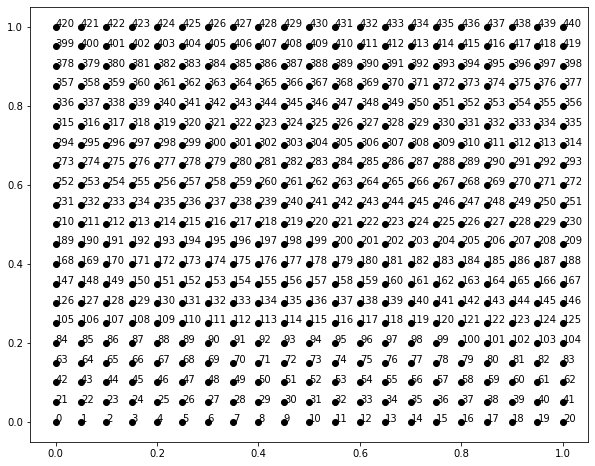

In [377]:
plot_nodes(NODES, 1, 1)

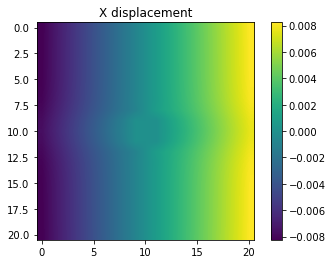

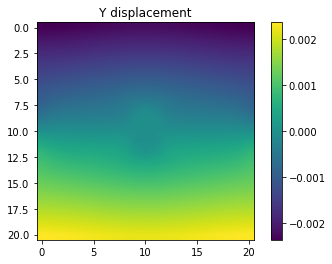

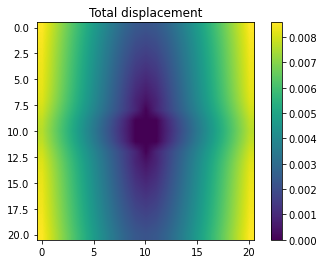

In [478]:
plt.figure(1)
plt.imshow(Ux, interpolation='bilinear')
plt.title("X displacement")
plt.colorbar()
plt.show()

plt.figure(2)
plt.imshow(Uy, interpolation='bilinear')
plt.title("Y displacement")
plt.colorbar()
plt.show()

plt.figure(3)
plt.imshow(U_tot, interpolation='bilinear')
plt.title("Total displacement")
plt.colorbar()
plt.show()
# [ 0.2762, -0.0773,  0.    ]

In [32]:
NODES = nodes_mat(m,n)
NODES

NameError: name 'nodes_mat' is not defined

In [46]:
mesh = RectangleQuadMesh(2, 1, 10, 10)
Lx = 2
Ly = 1

NameError: name 'RectangleQuadMesh' is not defined

In [75]:
x = np.linspace(0, Lx, mesh.nodes_x)
y = np.linspace(0, Ly, mesh.nodes_y)

coords = []
for yi in y:
    for xi in x:
        coords.append([xi,yi])
        
coords = np.array(coords)

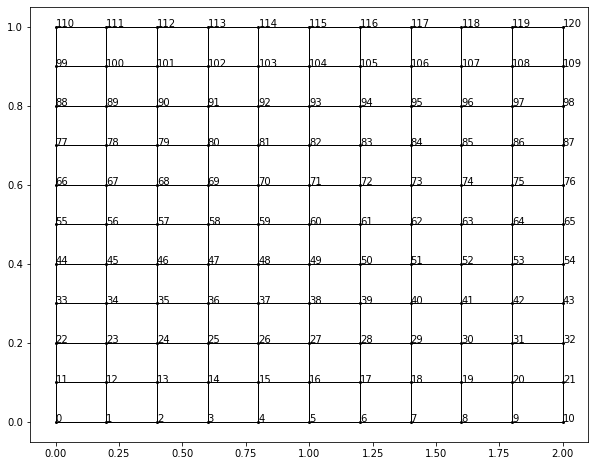

In [77]:
coords.transpose()

array([[0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 0. , 0.2,
        0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 0. , 0.2, 0.4, 0.6,
        0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 0. , 0.2, 0.4, 0.6, 0.8, 1. ,
        1.2, 1.4, 1.6, 1.8, 2. , 0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4,
        1.6, 1.8, 2. , 0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8,
        2. , 0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 0. ,
        0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 0. , 0.2, 0.4,
        0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 0. , 0.2, 0.4, 0.6, 0.8,
        1. , 1.2, 1.4, 1.6, 1.8, 2. , 0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2,
        1.4, 1.6, 1.8, 2. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0.1,
        0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2,
        0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
        0.3, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
        0.4, 0.4, 0.4,